In [1]:
# RESTART KERNEL FIRST - Use Kernel > Restart Kernel from the menu
# This cell should be run ONLY after restarting the kernel to ensure a clean state

import sys
import importlib

# Clear all modules to ensure clean import
modules_to_remove = [m for m in sys.modules.keys() if any(x in m for x in ['quantstats', 'pandas'])]
for module in modules_to_remove:
    if module in sys.modules:
        del sys.modules[module]

print("Kernel cleared. Please restart the kernel manually and then run cells 2, 3, 4 in order.")
print("DO NOT run quantstats import until after the pandas patches are applied!")

Kernel cleared. Please restart the kernel manually and then run cells 2, 3, 4 in order.
DO NOT run quantstats import until after the pandas patches are applied!


In [2]:
# Load environment variables FIRST (before importing quantstats)
from dotenv import load_dotenv
import os
from pathlib import Path

# Load .env file from current directory
env_path = Path('.env')
load_dotenv(env_path)

print("Environment variables loaded. Now run the pandas patch cell.")

Environment variables loaded. Now run the pandas patch cell.


In [3]:
# Import pandas and apply patches BEFORE importing quantstats
import pandas as pd
from pandas.core.resample import Resampler
import warnings

# Store the TRULY original methods at import time
_original_series_resample = pd.core.series.Series.resample
_original_dataframe_resample = pd.core.frame.DataFrame.resample
_original_resampler_sum = Resampler.sum

def patched_series_resample(self, rule, *args, **kwargs):
    # Convert new pandas frequency strings to old ones, but suppress warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", FutureWarning)
        rule_mapping = {"YE": "Y", "ME": "M", "QE": "Q"}
        rule = rule_mapping.get(rule, rule)
        # Use the original method directly from the class
        return _original_series_resample(self, rule, *args, **kwargs)

def patched_dataframe_resample(self, rule, *args, **kwargs):
    # Convert new pandas frequency strings to old ones, but suppress warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", FutureWarning)
        rule_mapping = {"YE": "Y", "ME": "M", "QE": "Q"}
        rule = rule_mapping.get(rule, rule)
        # Use the original method directly from the class
        return _original_dataframe_resample(self, rule, *args, **kwargs)

def patched_resampler_sum(self, *args, **kwargs):
    # Remove axis parameter that causes issues
    kwargs.pop('axis', None)
    return _original_resampler_sum(self, *args, **kwargs)

# Apply the patches
pd.Series.resample = patched_series_resample
pd.DataFrame.resample = patched_dataframe_resample
Resampler.sum = patched_resampler_sum

print("Pandas patches applied successfully with warning suppression. Now you can import quantstats.")

Pandas patches applied successfully with warning suppression. Now you can import quantstats.


In [4]:
# Now import quantstats AFTER pandas is patched
%matplotlib inline
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

print("Quantstats imported successfully with patches applied!")

Quantstats imported successfully with patches applied!


In [5]:
# Comprehensive patches for plotting compatibility issues
import quantstats._plotting.core as qs_core
import quantstats._plotting.wrappers as qs_wrappers

# Store original plotting functions
_original_plot_histogram = qs_core.plot_histogram
_original_plot_distribution = qs_core.plot_distribution
_original_histogram_wrapper = qs_wrappers.histogram
_original_distribution_wrapper = qs_wrappers.distribution

def patched_plot_histogram(*args, **kwargs):
    try:
        return _original_plot_histogram(*args, **kwargs)
    except (AssertionError, TypeError, AttributeError) as e:
        print(f"Histogram plot skipped due to compatibility issue: {e}")
        return None

def patched_plot_distribution(*args, **kwargs):
    try:
        return _original_plot_distribution(*args, **kwargs)
    except (AssertionError, TypeError, AttributeError) as e:
        print(f"Distribution plot skipped due to compatibility issue: {e}")
        return None

def patched_histogram_wrapper(*args, **kwargs):
    try:
        return _original_histogram_wrapper(*args, **kwargs)
    except (AssertionError, TypeError, AttributeError) as e:
        print(f"Histogram plot skipped due to compatibility issue: {e}")
        return None

def patched_distribution_wrapper(*args, **kwargs):
    try:
        return _original_distribution_wrapper(*args, **kwargs)
    except (AssertionError, TypeError, AttributeError) as e:
        print(f"Distribution plot skipped due to compatibility issue: {e}")
        return None

# Apply all plotting patches
qs_core.plot_histogram = patched_plot_histogram
qs_core.plot_distribution = patched_plot_distribution
qs_wrappers.histogram = patched_histogram_wrapper
qs_wrappers.distribution = patched_distribution_wrapper

print("All plotting patches applied - histogram and distribution plots will be skipped if incompatible.")

All plotting patches applied - histogram and distribution plots will be skipped if incompatible.


In [6]:
# Get path from environment variables
path_daily_returns_strategies = os.getenv('path_daily_returns_strategies')
path_daily_returns_spy = os.getenv('path_daily_returns_spy')

daily_returns_spy = pd.read_csv(path_daily_returns_spy, index_col=0, parse_dates=True, sep=';')
daily_returns_strategies = pd.read_csv(path_daily_returns_strategies, index_col=0, parse_dates=True, sep=';')

# Fix: Normalize dates to remove time component
daily_returns_spy.index = daily_returns_spy.index.normalize()
daily_returns_strategies.index = daily_returns_strategies.index.normalize()

In [7]:
# rename the columns
daily_returns_spy.columns = ['daily_returns_spy']
daily_returns_strategies.columns = ['daily_returns_strategies']

In [8]:
daily_returns_spy

,daily_returns_spy
datetime,
2023-04-19,NaN
2023-04-20,-0.005457
2023-04-21,0.000777
2023-04-24,0.001043
2023-04-25,-0.015874
...,...
2025-10-27,0.011798
2025-10-28,0.002656
2025-10-29,0.000480


In [9]:
daily_returns_strategies

,daily_returns_strategies
Date,
2023-04-17,0.053095
2023-04-18,-0.000460
2023-04-19,-0.005545
2023-04-20,-0.000670
2023-04-21,0.004506
...,...
2025-10-27,0.005696
2025-10-28,0.000278
2025-10-29,-0.000141


In [10]:
# # Debug the merge issue
# print("SPY DataFrame info:")
# print(f"Shape: {daily_returns_spy.shape}")
# print(f"Date range: {daily_returns_spy.index.min()} to {daily_returns_spy.index.max()}")
# print(f"Has NaN values: {daily_returns_spy.isna().sum().sum()}")
# print("\nStrategies DataFrame info:")
# print(f"Shape: {daily_returns_strategies.shape}")
# print(f"Date range: {daily_returns_strategies.index.min()} to {daily_returns_strategies.index.max()}")
# print(f"Has NaN values: {daily_returns_strategies.isna().sum().sum()}")

# # Check for overlapping dates
# common_dates = daily_returns_spy.index.intersection(daily_returns_strategies.index)
# print(f"\nNumber of common dates: {len(common_dates)}")

# if len(common_dates) > 0:
#     print(f"Common date range: {common_dates.min()} to {common_dates.max()}")
# else:
#     print("No overlapping dates found!")
#     print("\nSPY sample dates:")
#     print(daily_returns_spy.index[:5].tolist())
#     print("\nStrategies sample dates:")
#     print(daily_returns_strategies.index[:5].tolist())

# # Try a different merge approach
# merged_df = pd.merge(daily_returns_spy, daily_returns_strategies, left_index=True, right_index=True, how='inner')
# print(f"\nMerged DataFrame shape before dropna: {merged_df.shape}")

# # Check what's in the merged dataframe before dropping NAs
# print(f"NaN count in merged_df:")
# print(merged_df.isna().sum())

# # Drop NA values
# merged_df = merged_df.dropna()
# print(f"Merged DataFrame shape after dropna: {merged_df.shape}")

# # Only try to sample if we have data
# if len(merged_df) > 0:
#     print(f"\nSample of merged data:")
#     sample_size = min(10, len(merged_df))
#     print(merged_df.sample(sample_size))
# else:
#     print("No data available after merge and dropna!")

In [11]:
# merge the two dataframes on the index (now with normalized dates)
merged_df = pd.merge(daily_returns_spy, daily_returns_strategies, left_index=True, right_index=True, how='inner')

# drop na values
merged_df = merged_df.dropna()

print(f"Merged DataFrame shape: {merged_df.shape}")
merged_df

Merged DataFrame shape: (577, 2)


,daily_returns_spy,daily_returns_strategies
2023-04-20,-0.005457,-0.000670
2023-04-21,0.000777,0.004506
2023-04-24,0.001043,-0.008464
2023-04-26,-0.004236,0.058882
2023-04-28,0.008535,0.000161
...,...,...
2025-10-27,0.011798,0.005696
2025-10-28,0.002656,0.000278
2025-10-29,0.000480,-0.000141
2025-10-30,-0.010998,0.003372


In [12]:
# Safe sampling - check if DataFrame has data first
if len(merged_df) > 0:
    sample_size = min(10, len(merged_df))
    merged_df.sample(sample_size)
else:
    print("No data available in merged_df")

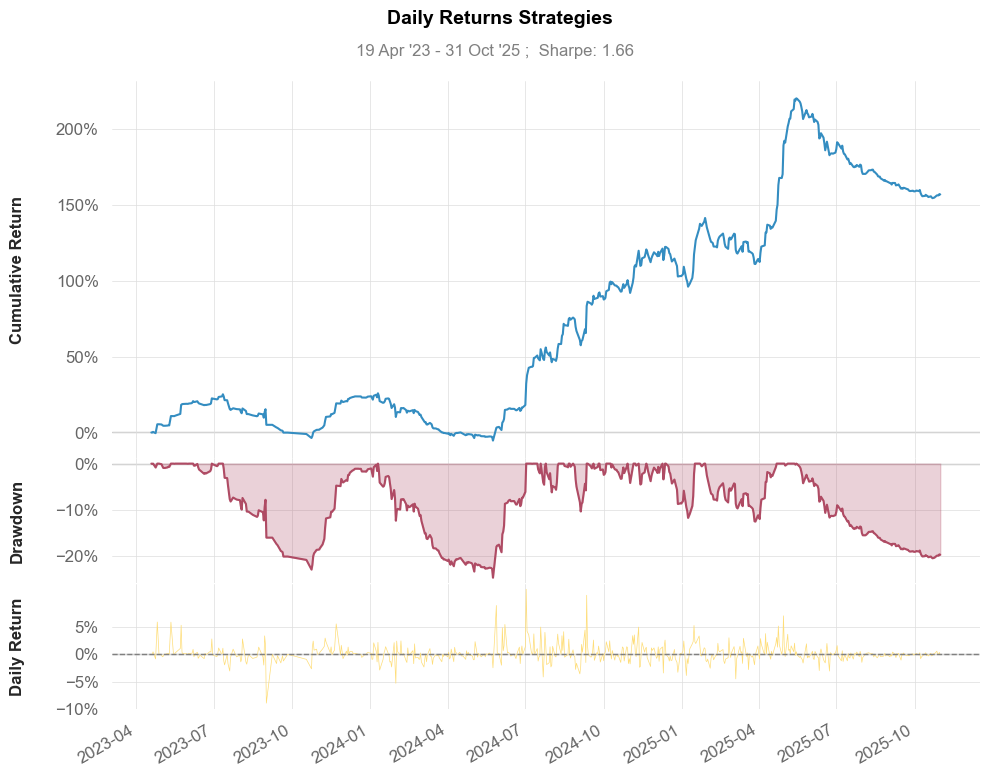

In [13]:
# plot daily_returns_strategies
qs.plots.snapshot(merged_df['daily_returns_strategies'], title='Daily Returns Strategies', show=True)


In [14]:
# shows basic/full metrics
qs.reports.metrics(benchmark=merged_df['daily_returns_spy'],
                   returns=merged_df['daily_returns_strategies'],
                   mode='basic',
                   title='Daily Returns Strategies',
                   display=True,
                   download=True,
                   output='daily_returns_strategies.html')

                     Benchmark    Strategy
-------------------  -----------  ----------
Start Period         2023-04-20   2023-04-20
End Period           2025-10-31   2025-10-31
Risk-Free Rate       0.0%         0.0%
Time in Market       100.0%       100.0%

Cumulative Return    72.58%       156.64%
CAGR﹪               26.91%       50.93%

Sharpe               1.58         1.66
Prob. Sharpe Ratio   99.3%        99.66%
Sortino              2.4          3.08
Sortino/√2           1.69         2.18
Omega                1.42         1.42

Max Drawdown         -19.0%       -24.75%
Max DD Date          2025-04-08   2024-05-24
Max DD Period Start  2025-02-20   2024-01-11
Max DD Period End    2025-06-26   2024-07-01
Longest DD Days      127          181

Gain/Pain Ratio      0.35         0.42
Gain/Pain (1M)       2.93         1.34

Payoff Ratio         1.21         1.42
Profit Factor        1.35         1.42
Common Sense Ratio   1.27         2.28
CPC Index            0.97         0.98
Tail Rati

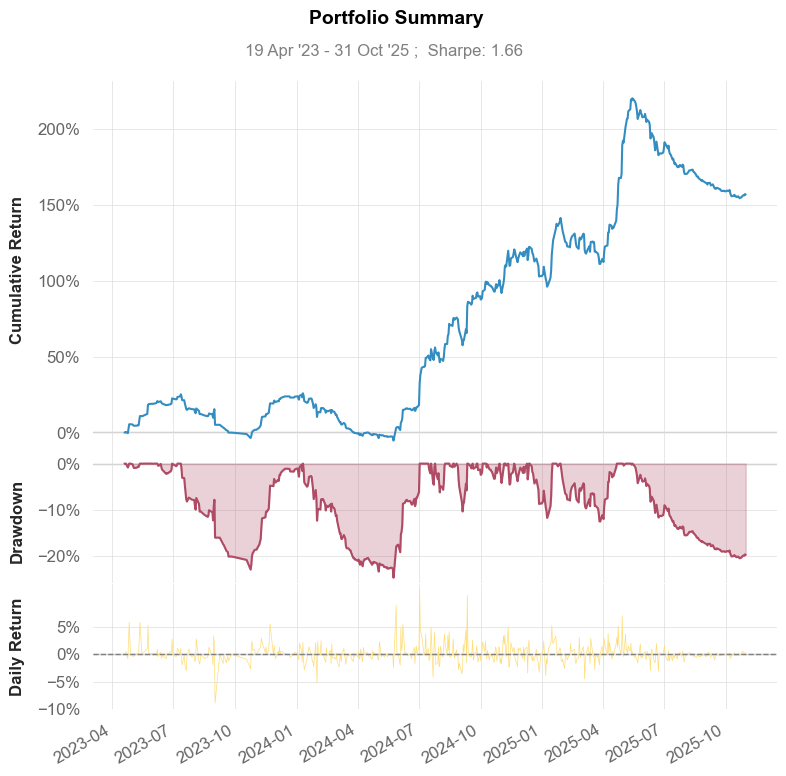

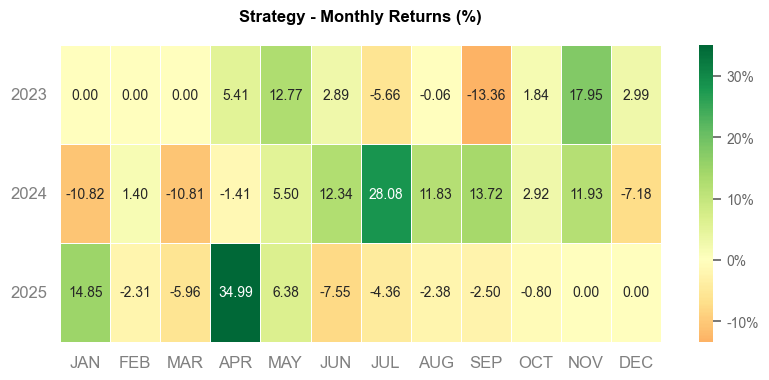

In [15]:
# shows basic/full plots - using basic mode to avoid histogram issues
qs.reports.plots(returns=merged_df['daily_returns_strategies'],
                  benchmark=merged_df['daily_returns_spy'],
                  mode='basic',  # Changed from 'full' to 'basic'
                  title='Daily Returns Strategies',
                  display=True,
                  download=True,
                  output='daily_returns_strategies.html')

                     Benchmark    Strategy
-------------------  -----------  ----------
Start Period         2023-04-20   2023-04-20
End Period           2025-10-31   2025-10-31
Risk-Free Rate       0.0%         0.0%
Time in Market       100.0%       100.0%

Cumulative Return    72.58%       156.64%
CAGR﹪               26.91%       50.93%

Sharpe               1.58         1.66
Prob. Sharpe Ratio   99.3%        99.66%
Sortino              2.4          3.08
Sortino/√2           1.69         2.18
Omega                1.42         1.42

Max Drawdown         -19.0%       -24.75%
Max DD Date          2025-04-08   2024-05-24
Max DD Period Start  2025-02-20   2024-01-11
Max DD Period End    2025-06-26   2024-07-01
Longest DD Days      127          181

Gain/Pain Ratio      0.35         0.42
Gain/Pain (1M)       2.93         1.34

Payoff Ratio         1.21         1.42
Profit Factor        1.35         1.42
Common Sense Ratio   1.27         2.28
CPC Index            0.97         0.98
Tail Rati

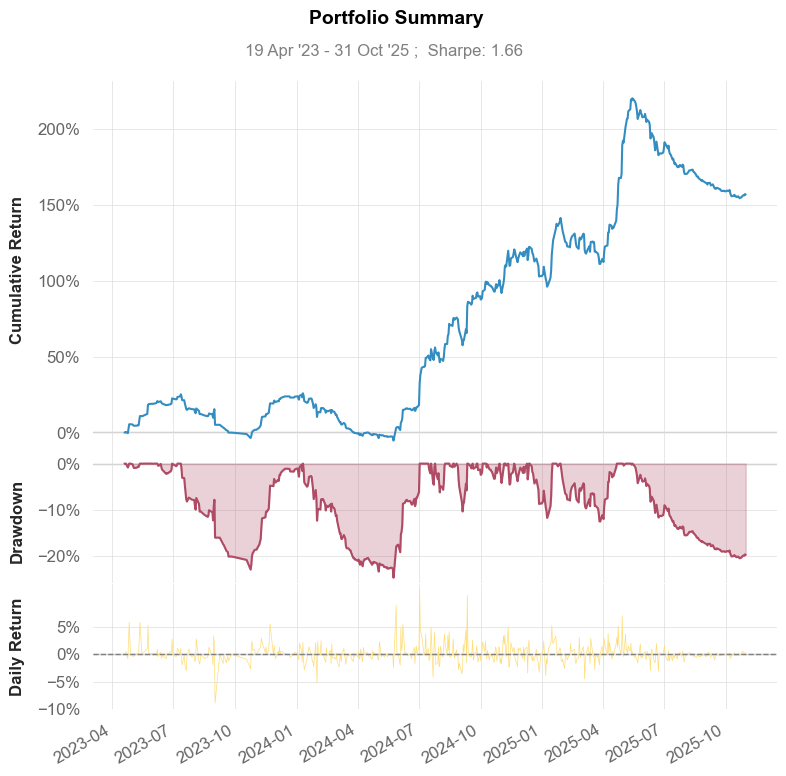

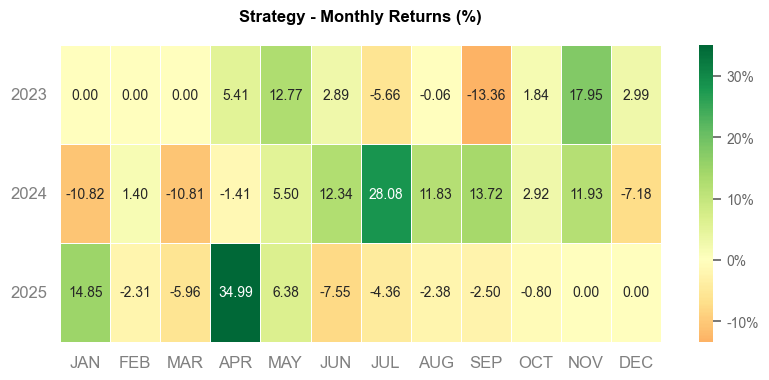

In [16]:
# shows basic metrics and plots
qs.reports.basic(returns=merged_df['daily_returns_strategies'],
                  benchmark=merged_df['daily_returns_spy'],
                  mode='basic',
                  title='Daily Returns Strategies',
                  display=True,
                  download=True,
                  output='daily_returns_strategies.html')

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2023-04-20   2023-04-20
End Period                 2025-10-31   2025-10-31
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          72.58%       156.64%
CAGR﹪                     26.91%       50.93%

Sharpe                     1.58         1.66
Prob. Sharpe Ratio         99.3%        99.66%
Smart Sharpe               1.44         1.51
Sortino                    2.4          3.08
Smart Sortino              2.18         2.8
Sortino/√2                 1.69         2.18
Smart Sortino/√2           1.54         1.98
Omega                      1.42         1.42

Max Drawdown               -19.0%       -24.75%
Max DD Date                2025-04-08   2024-05-24
Max DD Period Start        2025-02-20   2024-01-11
Max DD Period End          2025-06-26   2024-07-01
Longest DD Days            127          181
Vol

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-01-11,2024-05-24,2024-07-01,173,-24.752014,-22.848320
2,2023-07-13,2023-10-24,2024-01-09,181,-22.995364,-21.955863
3,2025-05-16,2025-10-22,2025-10-31,169,-20.538577,-20.431262
4,2025-01-29,2025-03-28,2025-04-21,83,-12.571304,-12.520487
5,2024-12-16,2025-01-08,2025-01-15,31,-11.781220,-10.906337


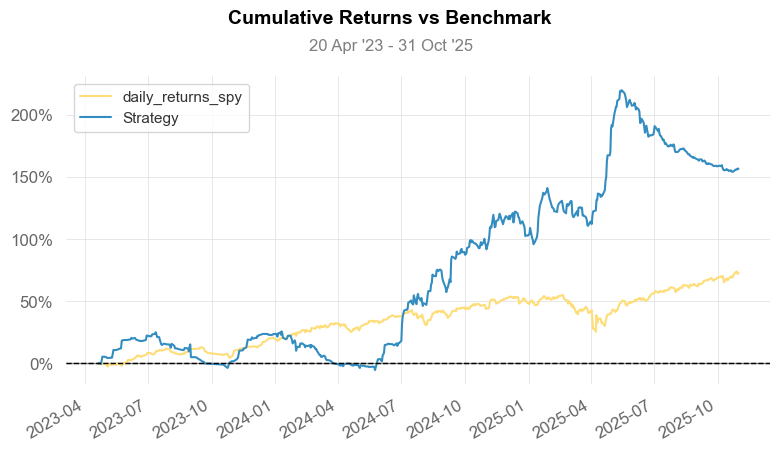

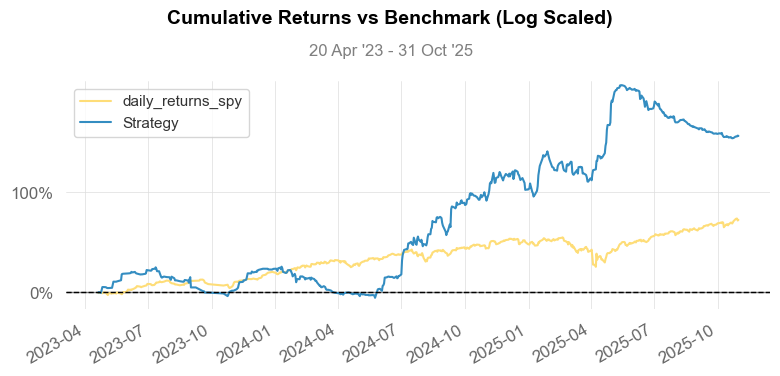

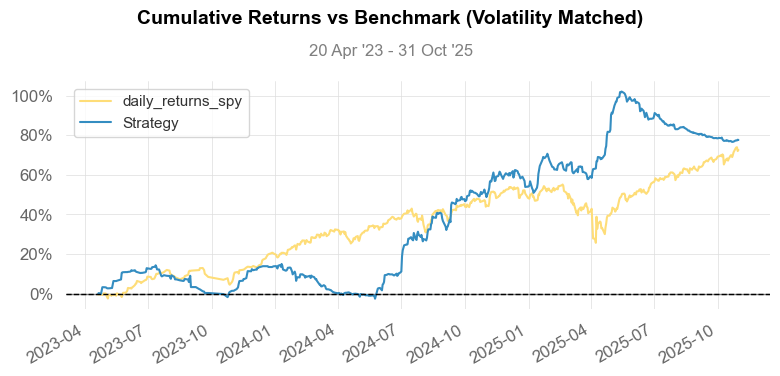

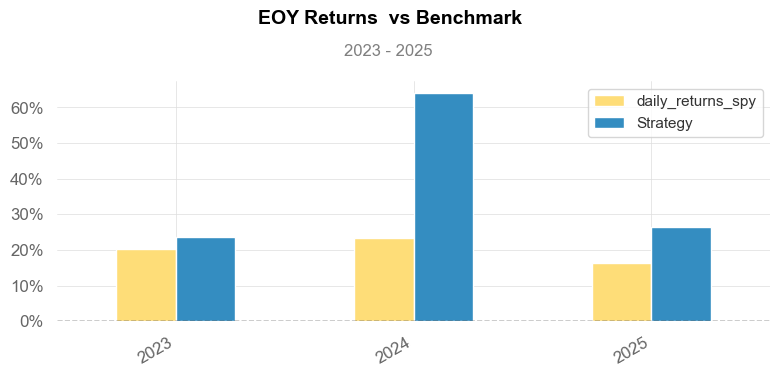

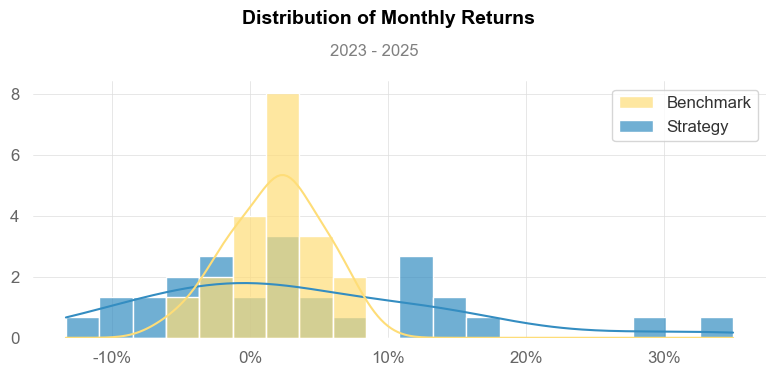

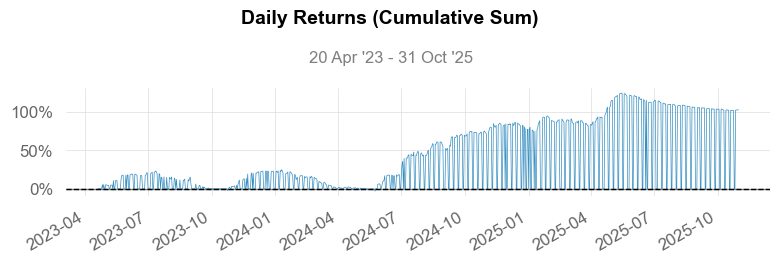

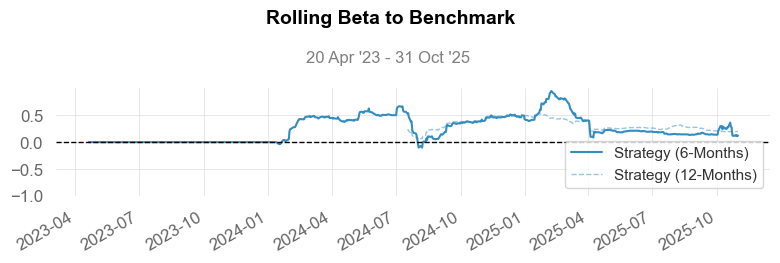

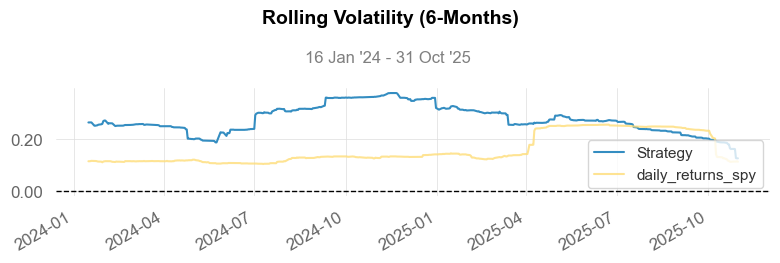

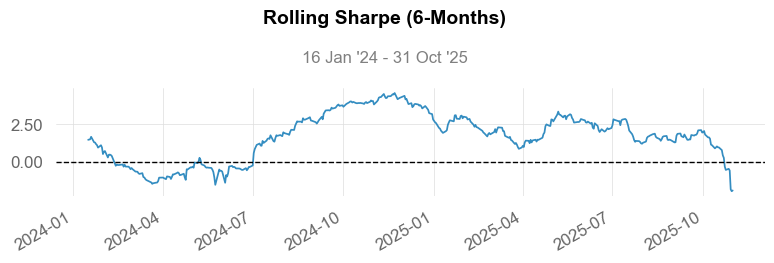

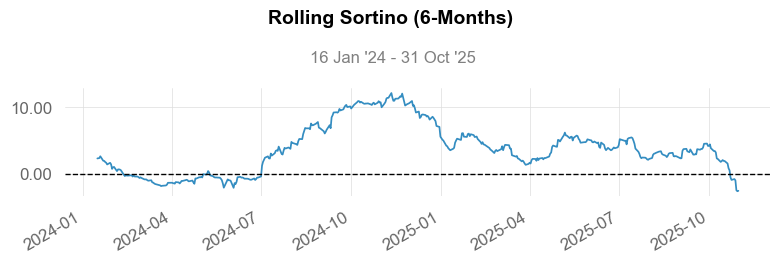

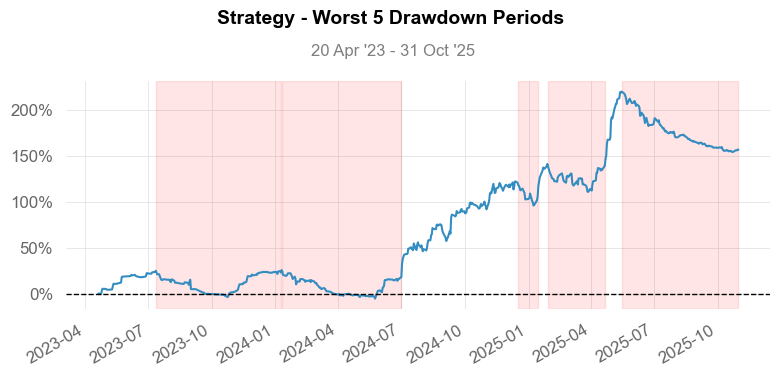

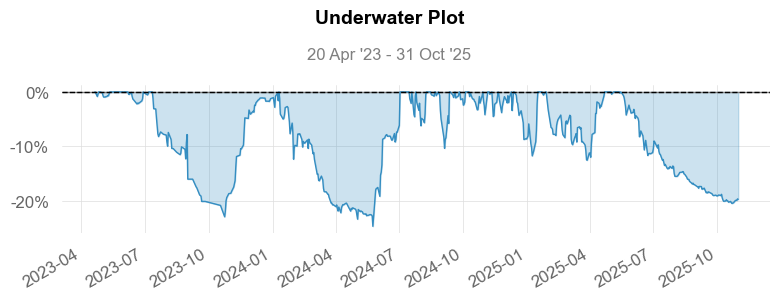

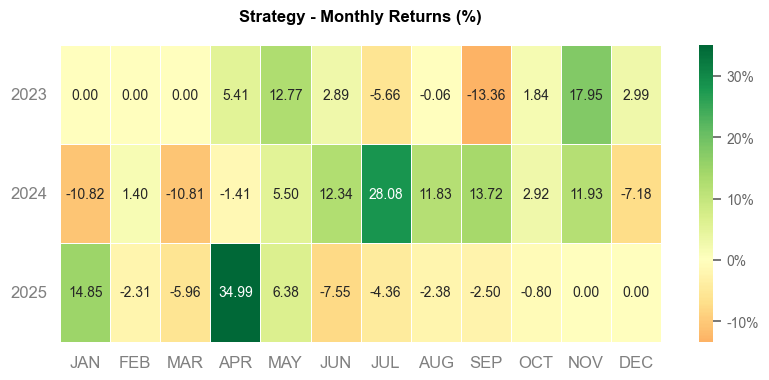

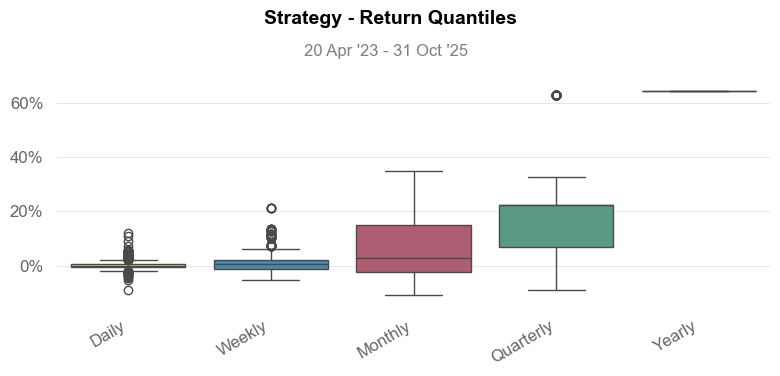

In [17]:
# shows full metrics and plots - using basic mode to avoid plotting compatibility issues
qs.reports.full(returns=merged_df['daily_returns_strategies'],
                  benchmark=merged_df['daily_returns_spy'],
                  mode='basic',  # Changed from 'full' to 'basic' to avoid plot compatibility issues
                  title='Daily Returns Strategies',
                  display=True,
                  download=True,
                  output='daily_returns_strategies.html')

In [18]:
# generates a complete report as html - with error handling
try:
    qs.reports.html(returns=merged_df['daily_returns_strategies'],
                     benchmark=merged_df['daily_returns_spy'],
                     title='Daily Returns Strategies',
                     display=True,
                     download=True,
                     output='daily_returns_strategies.html')
    print("HTML report generated successfully!")
except Exception as e:
    print(f"HTML report generation had issues: {e}")
    print("Some plots may be missing from the report due to compatibility issues, but the report should still contain metrics and working visualizations.")

HTML report generated successfully!
